In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# GRU

In [ ]:
VOCAB_SIZE = 300
SEQ_LEN = 100

In [ ]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=VOCAB_SIZE)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import torch
train_input = [torch.tensor(seq, dtype=torch.long) for seq in train_input]
test_input = [torch.tensor(seq, dtype=torch.long) for seq in test_input]

train_target = torch.tensor(train_target, dtype=torch.long)
test_target = torch.tensor(test_target, dtype=torch.long)

print(len(train_input), len(test_input))
print(train_target.shape, test_target.shape)

25000 25000
torch.Size([25000]) torch.Size([25000])


In [ ]:
train_input, test_input = train_input[:10000], test_input[:5000]
train_target, test_target = train_target[:10000], test_target[:5000]


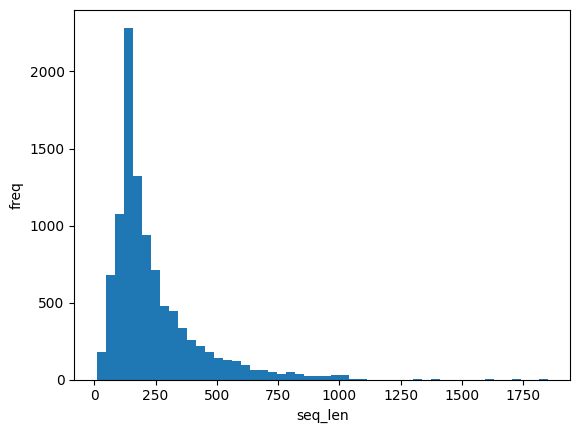

In [ ]:
# 입력 데이터 길이 체크
import matplotlib.pyplot as plt
import numpy as np

train_len = [len(seq) for seq in train_input]

plt.hist(train_len, bins=50)
plt.xlabel('seq_len')
plt.ylabel('freq')
plt.show()

In [ ]:
# padding 처리
import torch.nn.functional as F

def pad_sequences(sequences, maxlen, padding_value=0):
  padded_sequences = [F.pad(seq[:maxlen], (0, max(0, maxlen-len(seq))), value=padding_value) for seq in sequences]
  return torch.stack(padded_sequences)

train_seq = pad_sequences(train_input, maxlen=SEQ_LEN)
test_seq = pad_sequences(test_input, maxlen=SEQ_LEN)

train_seq.shape, test_seq.shape

(torch.Size([10000, 100]), torch.Size([5000, 100]))

In [ ]:
# one-hot encoding
train_onehot = F.one_hot(train_seq, num_classes=VOCAB_SIZE).float()
test_onehot = F.one_hot(test_seq, num_classes=VOCAB_SIZE).float()

train_onehot.shape, test_onehot.shape

(torch.Size([10000, 100, 300]), torch.Size([5000, 100, 300]))

### 모델 준비 및 학습

In [ ]:
import torch
import torch.nn as nn

class GRUModel(nn.Module):
  def __init__(self, input_dim, hidden_unit, output_dim, return_sequences=False, return_state=False):
    super(GRUModel, self).__init__()
    self.return_sequences = return_sequences
    self.return_state = return_state
    self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_unit, batch_first=True)
    self.fc = nn.Linear(hidden_unit, output_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    output, hidden = self.gru(x)
    result_output = self.fc(hidden[-1])

    if self.return_sequences and self.return_state:
      return output, hidden[-1]
    elif self.return_sequences:
      return output
    elif self.return_state:
      return output[:, -1, :], hidden[-1]

    return self.sigmoid(result_output)